In [ ]:
!pip install google-colab
!pip install scikit-learn
!pip install scikit-learn-extra
!pip install pyclustering

In [11]:
from google.colab import files
import pandas as pd
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import jaccard_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import linkage, dendrogram
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric

In [3]:
uploaded = files.upload()

Saving UNVotes.csv to UNVotes.csv


In [6]:
file_path = list(uploaded.keys())[0]
votes = pd.read_csv(file_path)

<ipython-input-6-b5277769ed4f>:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  votes = pd.read_csv(file_path)


In [ ]:
# Filter the "vote" column and rename it to "votes"
votes = votes[votes['vote'] <= 3]
votes.rename(columns={'vote': 'votes'}, inplace=True)

# Add a "year" column by adding 1945 to the values of the "session" column
votes['year'] = votes['session'] + 1945

In [ ]:
# Define a function to convert "votes" column values
def convert_vote(vote):
    if vote == 1:
        return 1  # Yes
    elif vote == 2:
        return 0  # Abstain
    elif vote == 3:
        return -1  # No

# Apply the conversion function to the "votes" column
votes['converted_votes'] = votes['votes'].apply(convert_vote)

# Define the periods
periods = [(2011, 2013), (2014, 2016), (2017, 2019), (2020, 2022)]

# Define the selected countries
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA", "CAN",
                      "KOR", "PAK", "IRI", "ISR", "ESP", "SAU", "IDN", "ZAF", "UKR"]

# Initialize a dictionary to store pairwise distances for each period
pairwise_distances = {period: {} for period in periods}

# Calculate pairwise distances for each period
for period in periods:
    start_year, end_year = period

    # Filter data for the specific period and selected countries
    votes_period = votes[(votes['year'] >= start_year) & (votes['year'] <= end_year) &
                         (votes['Country'].isin(selected_countries))]

    # Ensure that each country has the same number of votes in the period
    countries = votes_period['Country'].unique()
    min_votes = min(votes_period[votes_period['Country'] == country]['converted_votes'].shape[0] for country in countries)
    votes_period = votes_period[votes_period.groupby('Country')['converted_votes'].transform(len) == min_votes]

    # Calculate pairwise distances for the specific period
    countries = votes_period['Country'].unique()
    for country1, country2 in combinations(countries, 2):
        votes_country1 = votes_period[votes_period['Country'] == country1]['converted_votes'].values
        votes_country2 = votes_period[votes_period['Country'] == country2]['converted_votes'].values
        distance = np.sum(np.abs(votes_country1 - votes_country2))
        pairwise_distances[period][(country1, country2)] = distance
        pairwise_distances[period][(country2, country1)] = distance  # Distance is symmetric

# Generate distance matrices for each period
distance_matrices = {}
for period, distances in pairwise_distances.items():
    countries = list(selected_countries)
    distance_matrix = pd.DataFrame(index=countries, columns=countries)
    for country1 in countries:
        for country2 in countries:
            distance_matrix.loc[country1, country2] = distances.get((country1, country2), 0)
    distance_matrices[period] = distance_matrix

# Print or visualize the distance matrices for each period
for period, distance_matrix in distance_matrices.items():
    print(f"Distance Matrix ({period[0]}-{period[1]}):")
    print(distance_matrix)
    print()

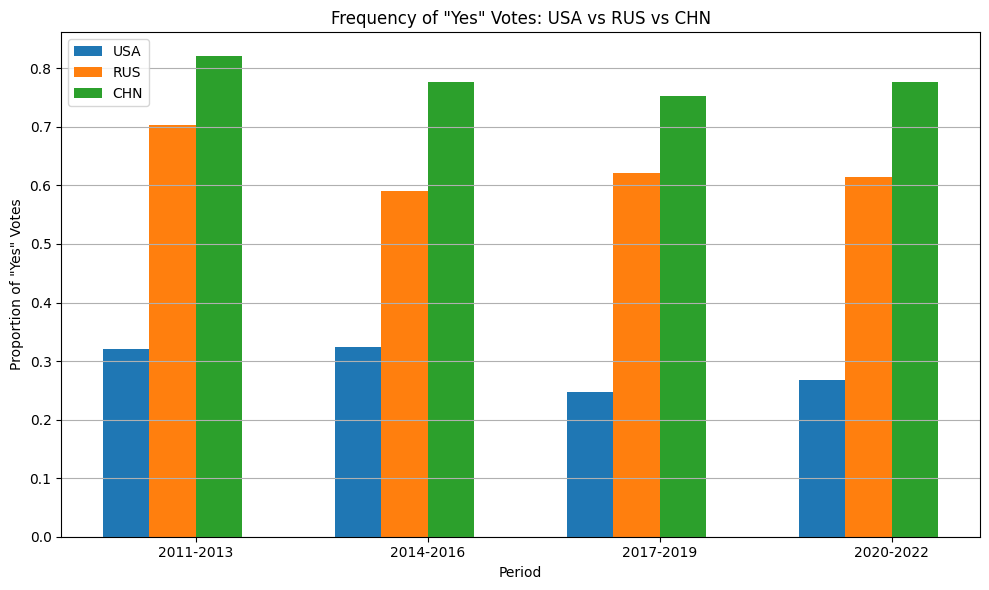

In [9]:
# Define the periods
periods = [(2011, 2013), (2014, 2016), (2017, 2019), (2020, 2022)]

# Countries to compare
countries = ['USA', 'RUS', 'CHN']

# Initialize lists to store frequency of "Yes" votes for each country
yes_votes = {country: [] for country in countries}

# Calculate frequency of "Yes" votes for each period and country
for start_year, end_year in periods:
    # Filter the data for the specified period
    period_data = votes[(votes['year'] >= start_year) & (votes['year'] <= end_year)]

    # Calculate proportion of "Yes" votes for each country
    for country in countries:
        country_data = period_data[period_data['Country'] == country]['votes']
        yes_prop = np.mean(country_data == 1)
        yes_votes[country].append(yes_prop)

# Visualize the comparisons using a grouped bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(periods))

for i, country in enumerate(countries):
    plt.bar(index + i * bar_width, yes_votes[country], bar_width, label=country)

plt.title('Frequency of "Yes" Votes: USA vs RUS vs CHN')
plt.xlabel('Period')
plt.ylabel('Proportion of "Yes" Votes')
plt.xticks(index + 1.5 * bar_width, [f'{start}-{end}' for start, end in periods])
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

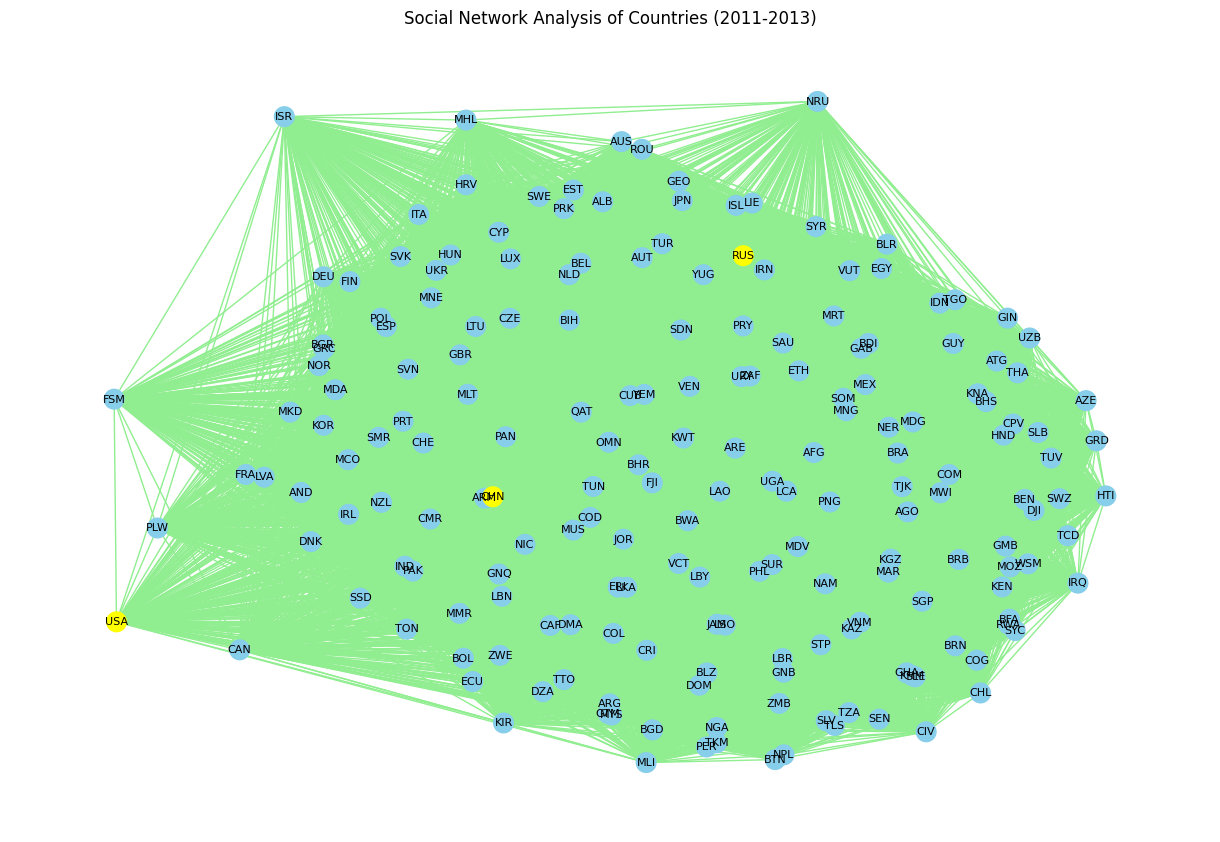

In [12]:
# Filter the data for the 2011-2013 period
votes_2011_2013 = votes[(votes['year'] >= 2011) & (votes['year'] <= 2013)]

# Pivot table to get "converted_votes" for each country
voting_data = votes_2011_2013.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between countries based on their "converted_votes"
distances = pairwise_distances(voting_data, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix = 1 / (1 + distances)

# Create a graph
G = nx.Graph()

# Add nodes for each country
G.add_nodes_from(voting_data.index)

# Add edges between nodes based on similarity
for i, country1 in enumerate(voting_data.index):
    for j, country2 in enumerate(voting_data.index):
        if i < j:
            similarity = similarity_matrix[i, j]
            if similarity > 0:  # Only add edges for non-zero similarities
                G.add_edge(country1, country2, weight=similarity)

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Define node colors
node_colors = {node: 'yellow' if node in ['USA', 'RUS', 'CHN'] else 'skyblue' for node in G.nodes()}

# Draw the graph with highlighted nodes
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=200, node_color=[node_colors[node] for node in G.nodes()], font_size=8, edge_color='lightgreen')
plt.title('Social Network Analysis of Countries (2011-2013)')
plt.show()

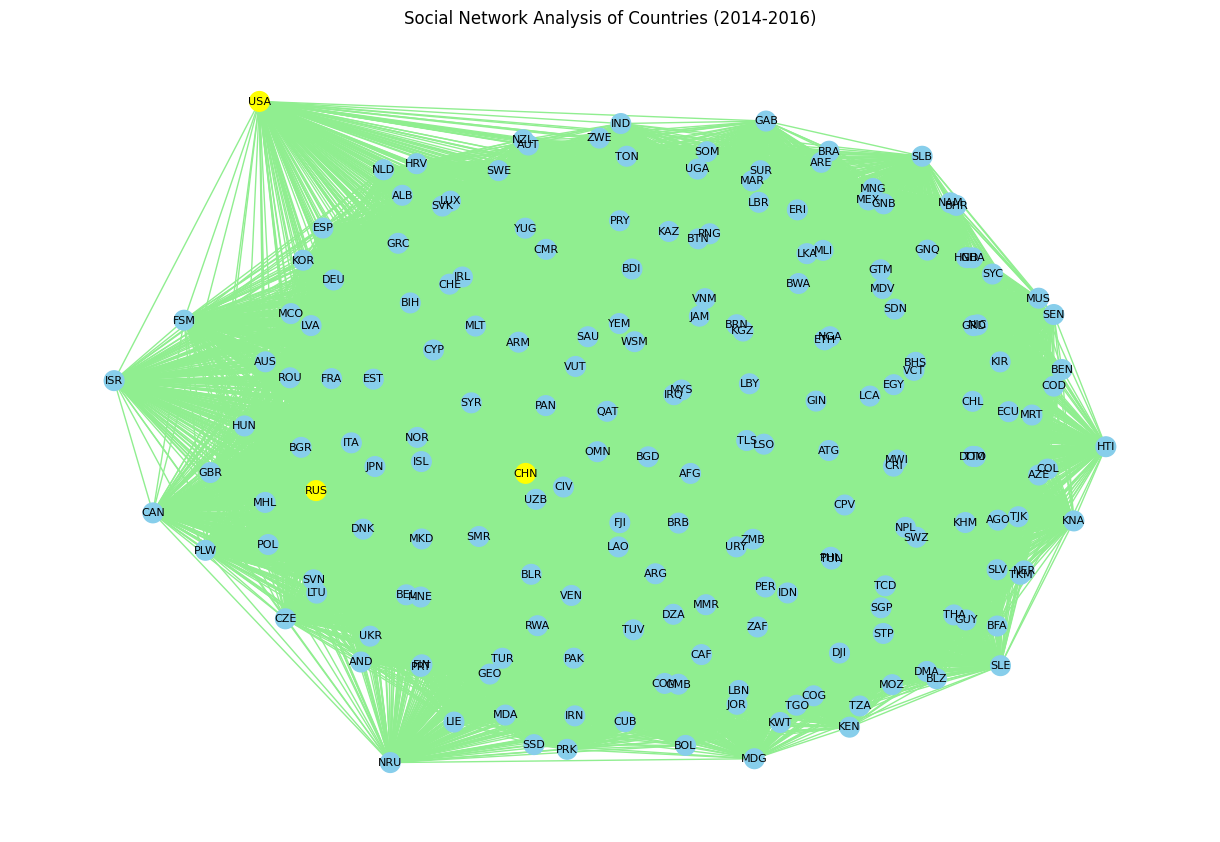

In [13]:
# Filter the data for the 2011-2013 period
votes_2014_2016 = votes[(votes['year'] >= 2014) & (votes['year'] <= 2016)]

# Pivot table to get "converted_votes" for each country
voting_data = votes_2014_2016.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between countries based on their "converted_votes"
distances = pairwise_distances(voting_data, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix = 1 / (1 + distances)

# Create a graph
G = nx.Graph()

# Add nodes for each country
G.add_nodes_from(voting_data.index)

# Add edges between nodes based on similarity
for i, country1 in enumerate(voting_data.index):
    for j, country2 in enumerate(voting_data.index):
        if i < j:
            similarity = similarity_matrix[i, j]
            if similarity > 0:  # Only add edges for non-zero similarities
                G.add_edge(country1, country2, weight=similarity)

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Define node colors
node_colors = {node: 'yellow' if node in ['USA', 'RUS', 'CHN'] else 'skyblue' for node in G.nodes()}

# Draw the graph with highlighted nodes
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=200, node_color=[node_colors[node] for node in G.nodes()], font_size=8, edge_color='lightgreen')
plt.title('Social Network Analysis of Countries (2014-2016)')
plt.show()

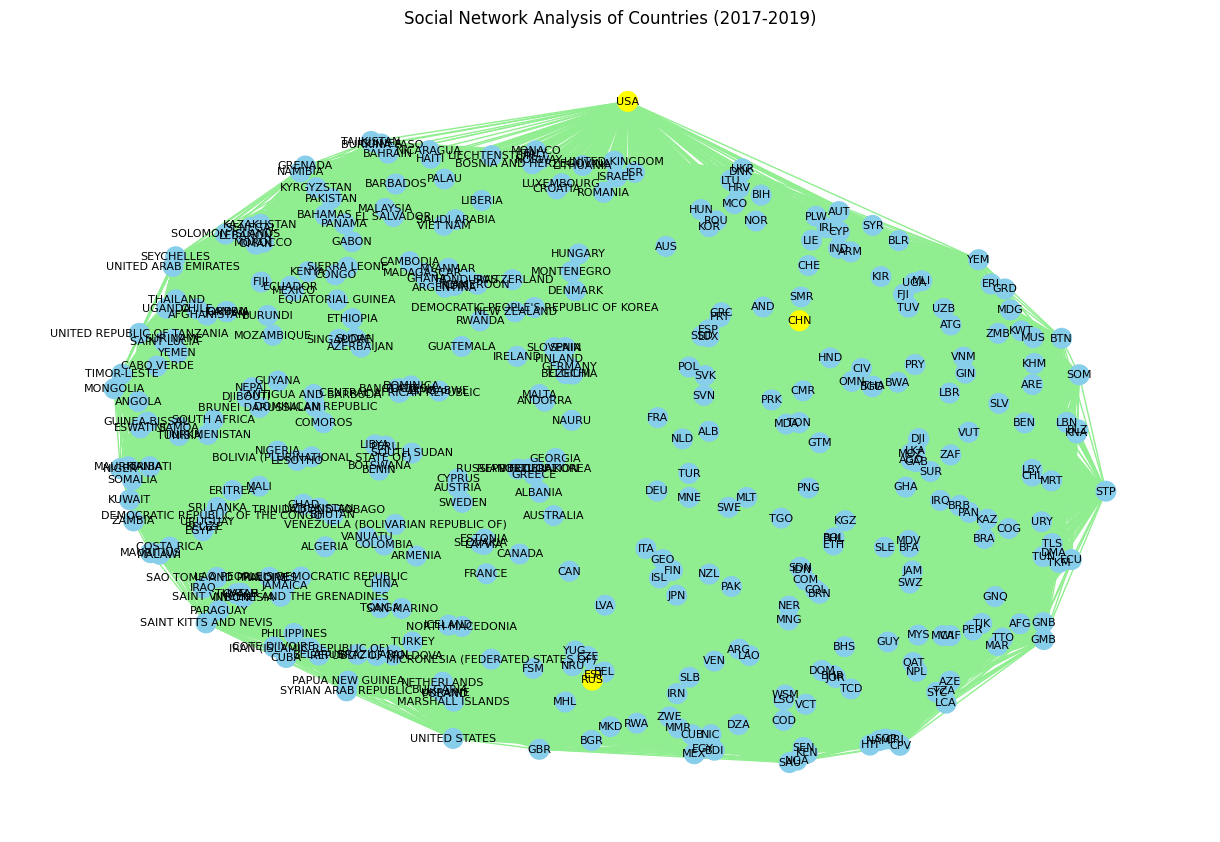

In [ ]:
# Filter the data for the 2017-2019 period
votes_2017_2019 = votes[(votes['year'] >= 2017) & (votes['year'] <= 2019)]

# Pivot table to get "converted_votes" for each country
voting_data = votes_2017_2019.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between countries based on their "converted_votes"
distances = pairwise_distances(voting_data, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix = 1 / (1 + distances)

# Create a graph
G = nx.Graph()

# Add nodes for each country
G.add_nodes_from(voting_data.index)

# Add edges between nodes based on similarity
for i, country1 in enumerate(voting_data.index):
    for j, country2 in enumerate(voting_data.index):
        if i < j:
            similarity = similarity_matrix[i, j]
            if similarity > 0:  # Only add edges for non-zero similarities
                G.add_edge(country1, country2, weight=similarity)

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Define node colors
node_colors = {node: 'yellow' if node in ['USA', 'RUS', 'CHN'] else 'skyblue' for node in G.nodes()}

# Draw the graph with highlighted nodes
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=200, node_color=[node_colors[node] for node in G.nodes()], font_size=8, edge_color='lightgreen')
plt.title('Social Network Analysis of Countries (2017-2019)')
plt.show()

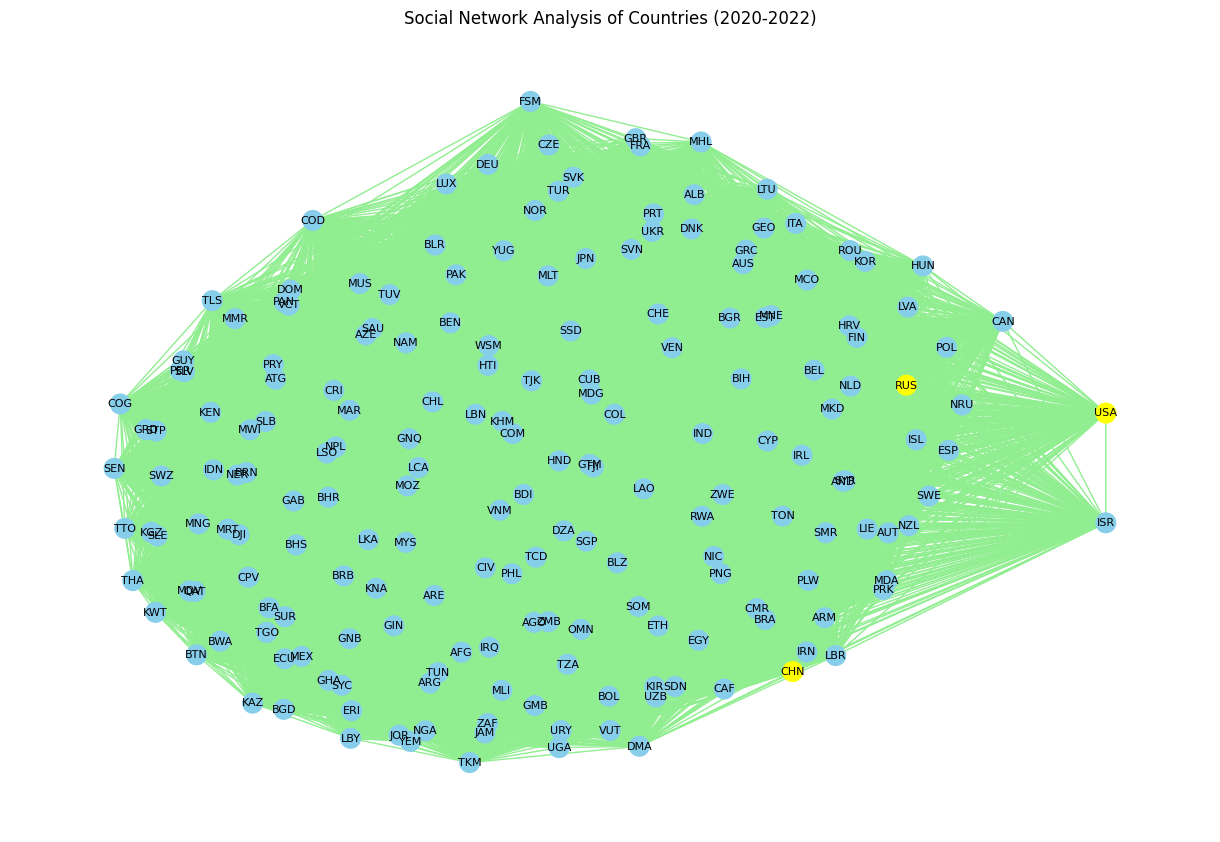

In [ ]:
# Filter the data for the 2020-2022 period
votes_2020_2022 = votes[(votes['year'] >= 2020) & (votes['year'] <= 2022)]

# Pivot table to get "converted_votes" for each country
voting_data = votes_2020_2022.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between countries based on their "converted_votes"
distances = pairwise_distances(voting_data, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix = 1 / (1 + distances)

# Create a graph
G = nx.Graph()

# Add nodes for each country
G.add_nodes_from(voting_data.index)

# Add edges between nodes based on similarity
for i, country1 in enumerate(voting_data.index):
    for j, country2 in enumerate(voting_data.index):
        if i < j:
            similarity = similarity_matrix[i, j]
            if similarity > 0:  # Only add edges for non-zero similarities
                G.add_edge(country1, country2, weight=similarity)

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Define node colors
node_colors = {node: 'yellow' if node in ['USA', 'RUS', 'CHN'] else 'skyblue' for node in G.nodes()}

# Draw the graph with highlighted nodes
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=200, node_color=[node_colors[node] for node in G.nodes()], font_size=8, edge_color='lightgreen')
plt.title('Social Network Analysis of Countries (2020-2022)')
plt.show()

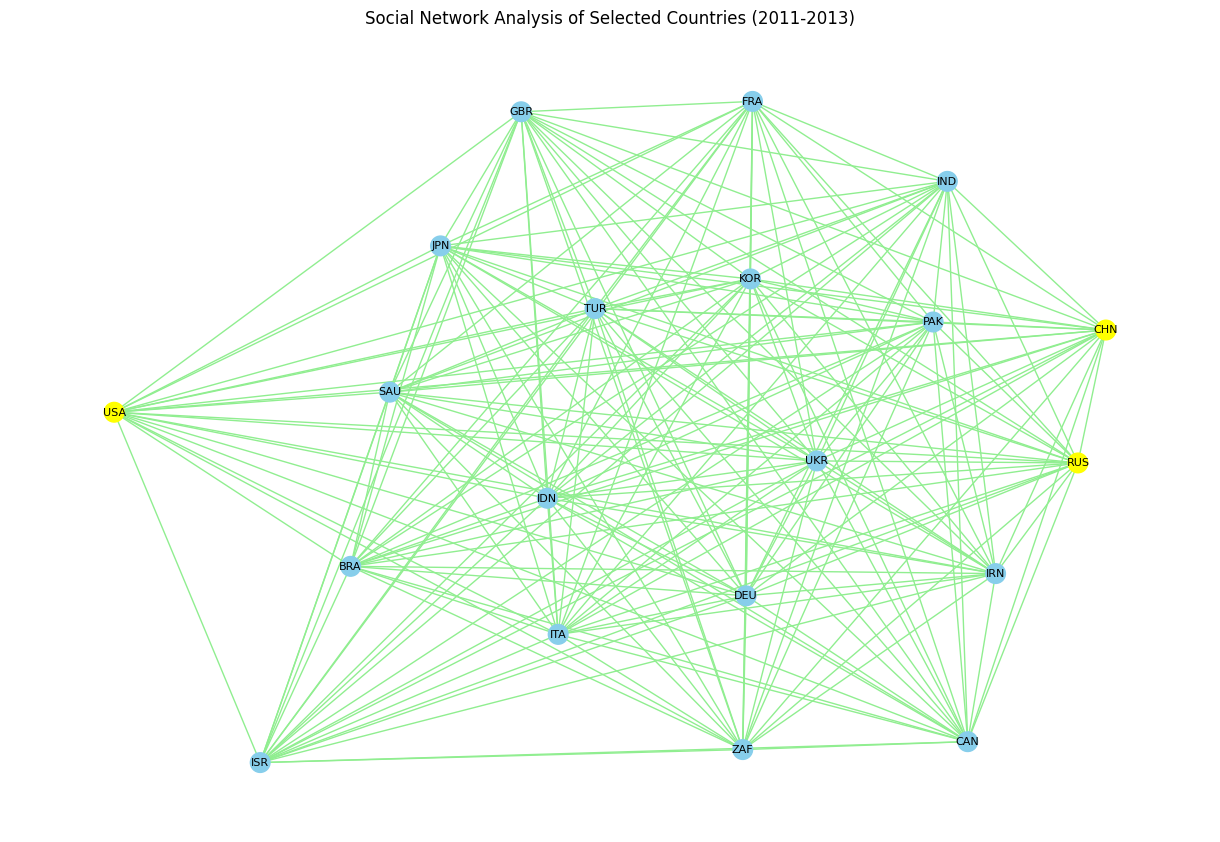

In [ ]:
# Define the selected group of countries
selected_countries = ["USA", "RUS", "CHN", "GBR", "FRA", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]

# Filter the data for the selected group of countries and the 2011-2013 period
votes_2011_2013_selected = votes[(votes['year'] >= 2011) & (votes['year'] <= 2013) & (votes['Country'].isin(selected_countries))]

# Pivot table to get "converted_votes" for each country
voting_data_selected = votes_2011_2013_selected.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between countries based on their "converted_votes"
distances_selected = pairwise_distances(voting_data_selected, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix_selected = 1 / (1 + distances_selected)

# Create a graph
G_selected = nx.Graph()

# Add nodes for each country
G_selected.add_nodes_from(voting_data_selected.index)

# Add edges between nodes based on similarity
for i, country1 in enumerate(voting_data_selected.index):
    for j, country2 in enumerate(voting_data_selected.index):
        if i < j:
            similarity = similarity_matrix_selected[i, j]
            if similarity > 0:  # Only add edges for non-zero similarities
                G_selected.add_edge(country1, country2, weight=similarity)

# Position nodes using spring layout
pos_selected = nx.spring_layout(G_selected)

# Define node colors
node_colors_selected = {node: 'yellow' if node in ["USA", "RUS", "CHN"] else 'skyblue' for node in G_selected.nodes()}

# Draw the graph with highlighted nodes
plt.figure(figsize=(12, 8))
nx.draw(G_selected, pos_selected, with_labels=True, node_size=200, node_color=[node_colors_selected[node] for node in G_selected.nodes()], font_size=8, edge_color='lightgreen')
plt.title('Social Network Analysis of Selected Countries (2011-2013)')
plt.show()

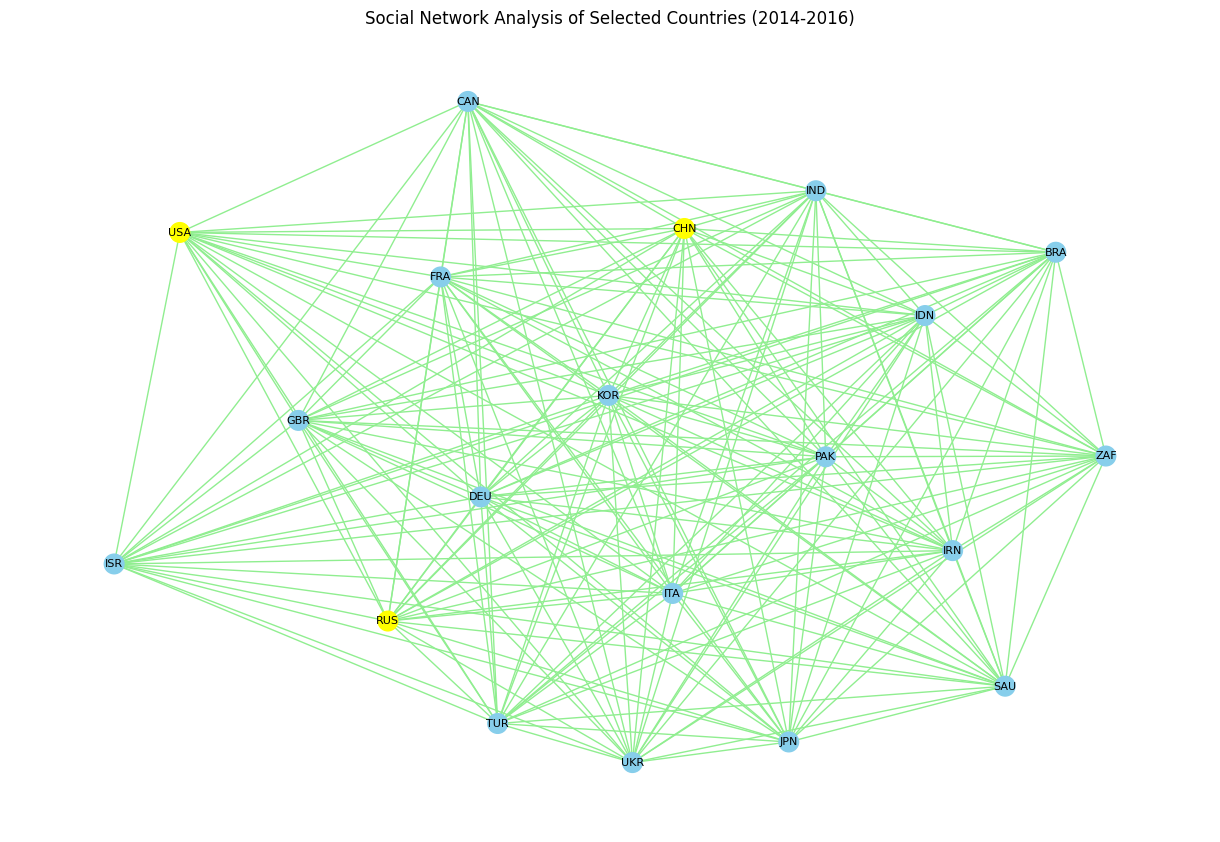

In [ ]:
# Define the selected group of countries
selected_countries = ["USA", "RUS", "CHN", "GBR", "FRA", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]

# Filter the data for the selected group of countries and the 2014-2016 period
votes_2014_2016_selected = votes[(votes['year'] >= 2014) & (votes['year'] <= 2016) & (votes['Country'].isin(selected_countries))]

# Pivot table to get "converted_votes" for each country
voting_data_selected = votes_2014_2016_selected.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between countries based on their "converted_votes"
distances_selected = pairwise_distances(voting_data_selected, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix_selected = 1 / (1 + distances_selected)

# Create a graph
G_selected = nx.Graph()

# Add nodes for each country
G_selected.add_nodes_from(voting_data_selected.index)

# Add edges between nodes based on similarity
for i, country1 in enumerate(voting_data_selected.index):
    for j, country2 in enumerate(voting_data_selected.index):
        if i < j:
            similarity = similarity_matrix_selected[i, j]
            if similarity > 0:  # Only add edges for non-zero similarities
                G_selected.add_edge(country1, country2, weight=similarity)

# Position nodes using spring layout
pos_selected = nx.spring_layout(G_selected)

# Define node colors
node_colors_selected = {node: 'yellow' if node in ["USA", "RUS", "CHN"] else 'skyblue' for node in G_selected.nodes()}

# Draw the graph with highlighted nodes
plt.figure(figsize=(12, 8))
nx.draw(G_selected, pos_selected, with_labels=True, node_size=200, node_color=[node_colors_selected[node] for node in G_selected.nodes()], font_size=8, edge_color='lightgreen')
plt.title('Social Network Analysis of Selected Countries (2014-2016)')
plt.show()

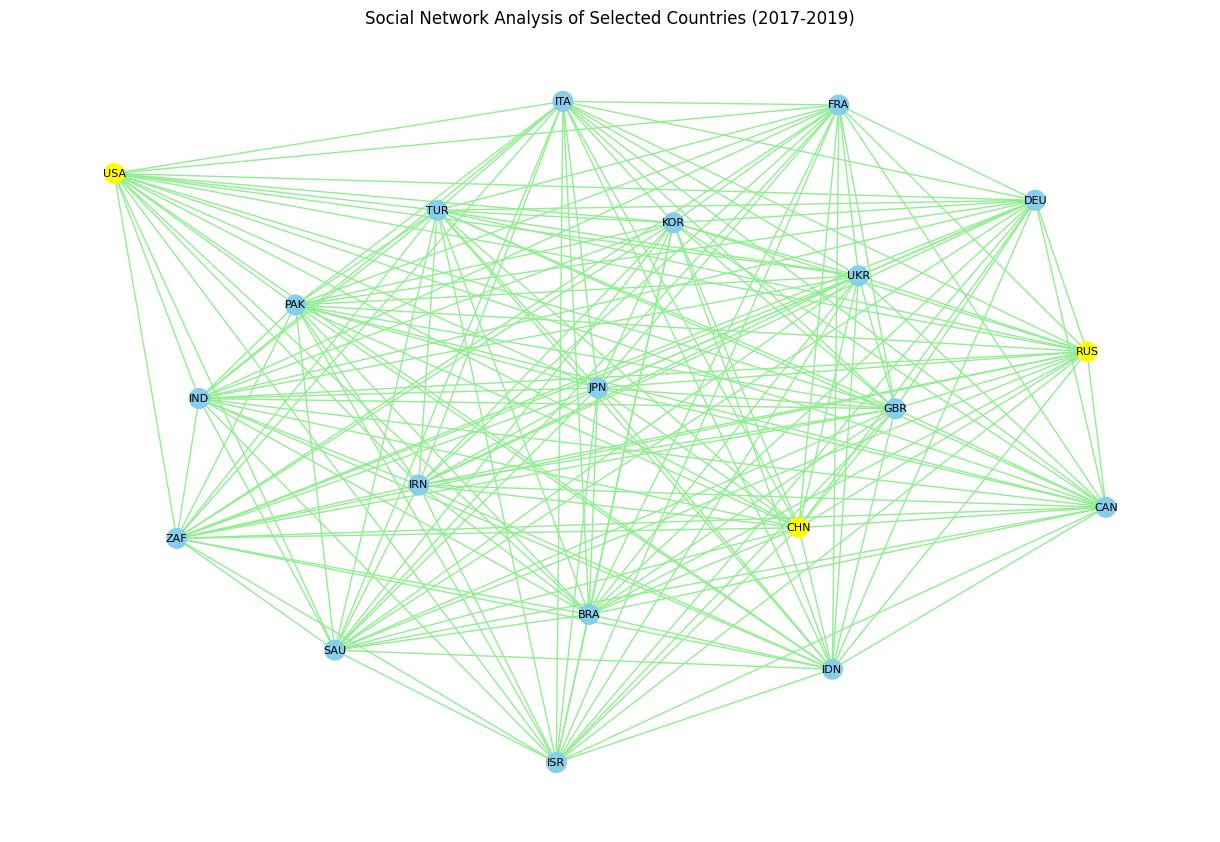

In [ ]:
# Define the selected group of countries
selected_countries = ["USA", "RUS", "CHN", "GBR", "FRA", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]

# Filter the data for the selected group of countries and the 2017-2019 period
votes_2017_2019_selected = votes[(votes['year'] >= 2017) & (votes['year'] <= 2019) & (votes['Country'].isin(selected_countries))]

# Pivot table to get "converted_votes" for each country
voting_data_selected = votes_2017_2019_selected.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between countries based on their "converted_votes"
distances_selected = pairwise_distances(voting_data_selected, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix_selected = 1 / (1 + distances_selected)

# Create a graph
G_selected = nx.Graph()

# Add nodes for each country
G_selected.add_nodes_from(voting_data_selected.index)

# Add edges between nodes based on similarity
for i, country1 in enumerate(voting_data_selected.index):
    for j, country2 in enumerate(voting_data_selected.index):
        if i < j:
            similarity = similarity_matrix_selected[i, j]
            if similarity > 0:  # Only add edges for non-zero similarities
                G_selected.add_edge(country1, country2, weight=similarity)

# Position nodes using spring layout
pos_selected = nx.spring_layout(G_selected)

# Define node colors
node_colors_selected = {node: 'yellow' if node in ["USA", "RUS", "CHN"] else 'skyblue' for node in G_selected.nodes()}

# Draw the graph with highlighted nodes
plt.figure(figsize=(12, 8))
nx.draw(G_selected, pos_selected, with_labels=True, node_size=200, node_color=[node_colors_selected[node] for node in G_selected.nodes()], font_size=8, edge_color='lightgreen')
plt.title('Social Network Analysis of Selected Countries (2017-2019)')
plt.show()

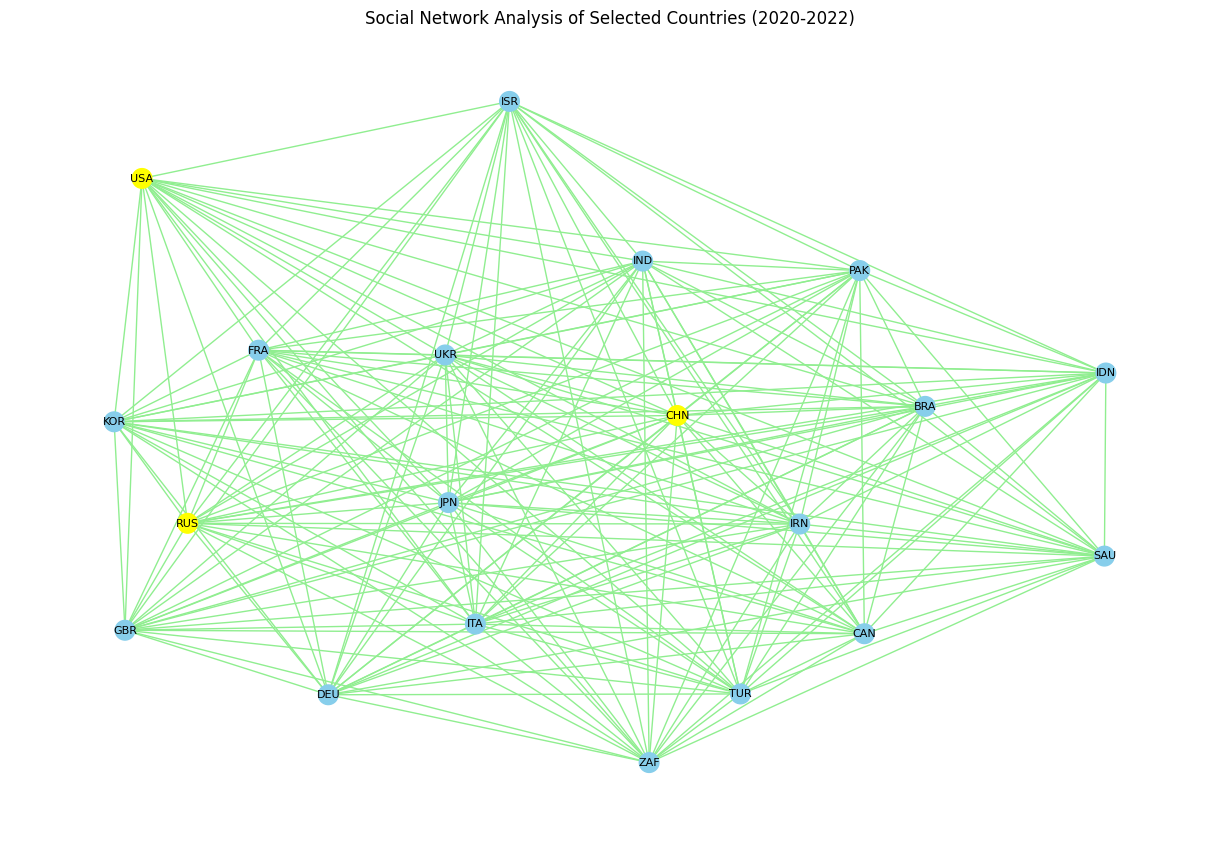

In [ ]:
# Define the selected group of countries
selected_countries = ["USA", "RUS", "CHN", "GBR", "FRA", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]

# Filter the data for the selected group of countries and the 2020-2022 period
votes_2020_2022_selected = votes[(votes['year'] >= 2020) & (votes['year'] <= 2022) & (votes['Country'].isin(selected_countries))]

# Pivot table to get "converted_votes" for each country
voting_data_selected = votes_2020_2022_selected.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between countries based on their "converted_votes"
distances_selected = pairwise_distances(voting_data_selected, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix_selected = 1 / (1 + distances_selected)

# Create a graph
G_selected = nx.Graph()

# Add nodes for each country
G_selected.add_nodes_from(voting_data_selected.index)

# Add edges between nodes based on similarity
for i, country1 in enumerate(voting_data_selected.index):
    for j, country2 in enumerate(voting_data_selected.index):
        if i < j:
            similarity = similarity_matrix_selected[i, j]
            if similarity > 0:  # Only add edges for non-zero similarities
                G_selected.add_edge(country1, country2, weight=similarity)

# Position nodes using spring layout
pos_selected = nx.spring_layout(G_selected)

# Define node colors
node_colors_selected = {node: 'yellow' if node in ["USA", "RUS", "CHN"] else 'skyblue' for node in G_selected.nodes()}

# Draw the graph with highlighted nodes
plt.figure(figsize=(12, 8))
nx.draw(G_selected, pos_selected, with_labels=True, node_size=200, node_color=[node_colors_selected[node] for node in G_selected.nodes()], font_size=8, edge_color='lightgreen')
plt.title('Social Network Analysis of Selected Countries (2020-2022)')
plt.show()

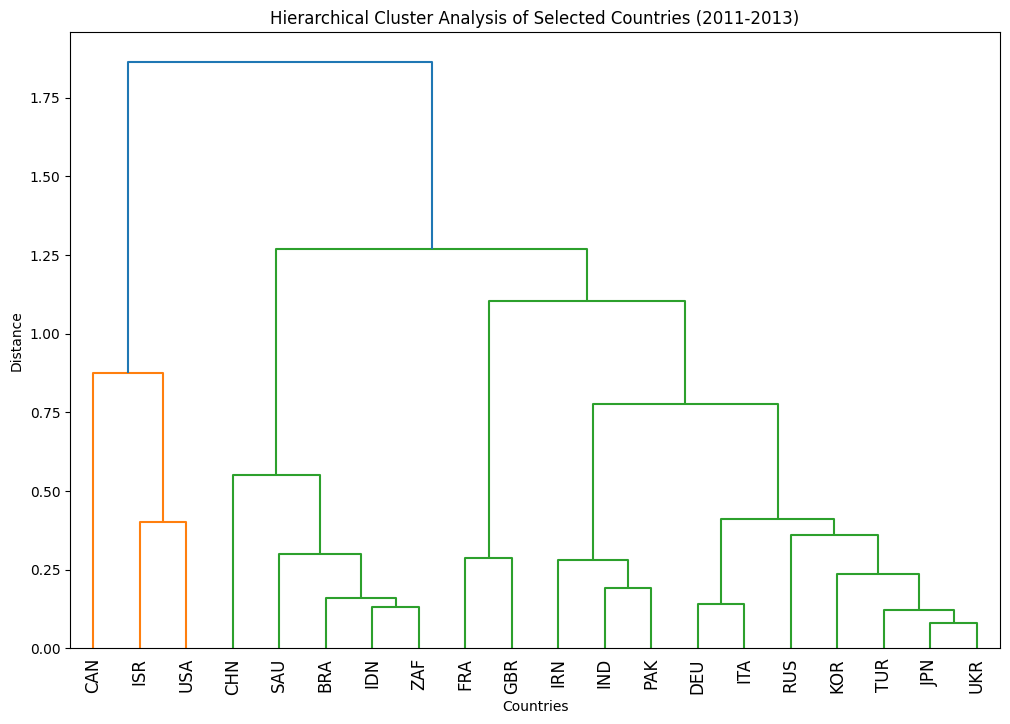

In [ ]:
# Define the selected group of countries
selected_countries = ["USA", "RUS", "CHN", "GBR", "FRA", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]

# Filter the data for the selected group of countries and the 2011-2013 period
votes_2011_2013_selected = votes[(votes['year'] >= 2011) & (votes['year'] <= 2013) & (votes['Country'].isin(selected_countries))]

# Pivot table to get "converted_votes" for each country
voting_data_selected = votes_2011_2013_selected.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between selected countries based on their "converted_votes"
distances_selected = pairwise_distances(voting_data_selected, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix_selected = 1 / (1 + distances_selected)

# Perform hierarchical clustering
linkage_matrix_selected = linkage(similarity_matrix_selected, method='average')  # You can choose other linkage methods as well

# Visualize the hierarchical clustering results as a dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix_selected, labels=voting_data_selected.index, leaf_rotation=90)
plt.title('Hierarchical Cluster Analysis of Selected Countries (2011-2013)')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.show()

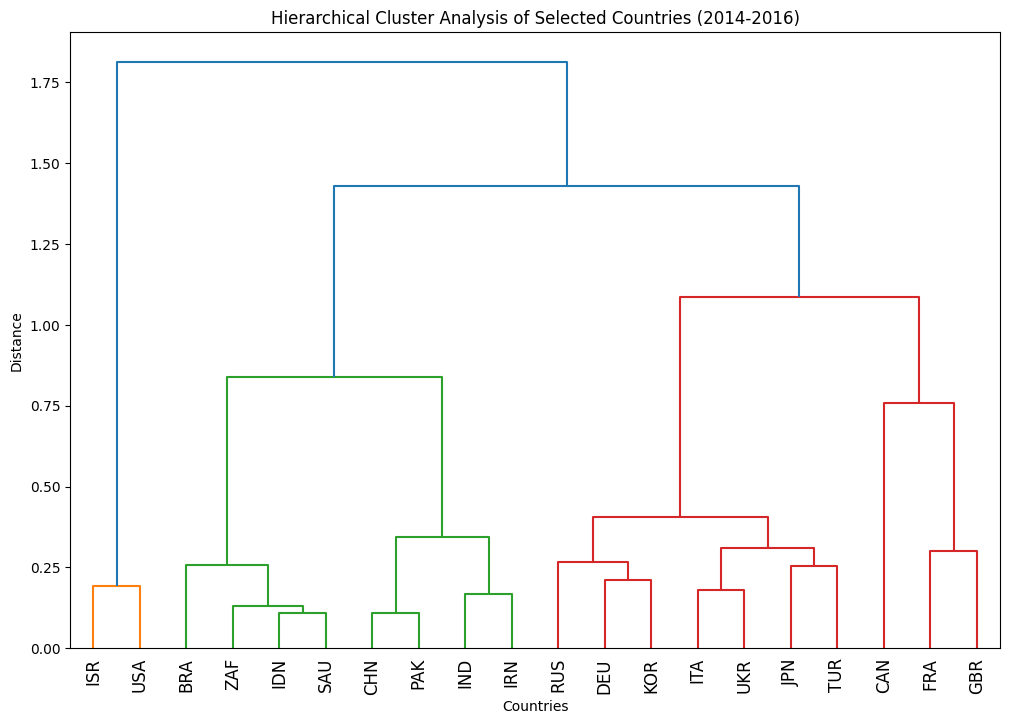

In [ ]:
# Define the selected group of countries
selected_countries = ["USA", "RUS", "CHN", "GBR", "FRA", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]

# Filter the data for the selected group of countries and the 2014-2016 period
votes_2014_2016_selected = votes[(votes['year'] >= 2014) & (votes['year'] <= 2016) & (votes['Country'].isin(selected_countries))]

# Pivot table to get "converted_votes" for each country
voting_data_selected = votes_2014_2016_selected.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between selected countries based on their "converted_votes"
distances_selected = pairwise_distances(voting_data_selected, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix_selected = 1 / (1 + distances_selected)

# Perform hierarchical clustering
linkage_matrix_selected = linkage(similarity_matrix_selected, method='average')  # You can choose other linkage methods as well

# Visualize the hierarchical clustering results as a dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix_selected, labels=voting_data_selected.index, leaf_rotation=90)
plt.title('Hierarchical Cluster Analysis of Selected Countries (2014-2016)')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.show()

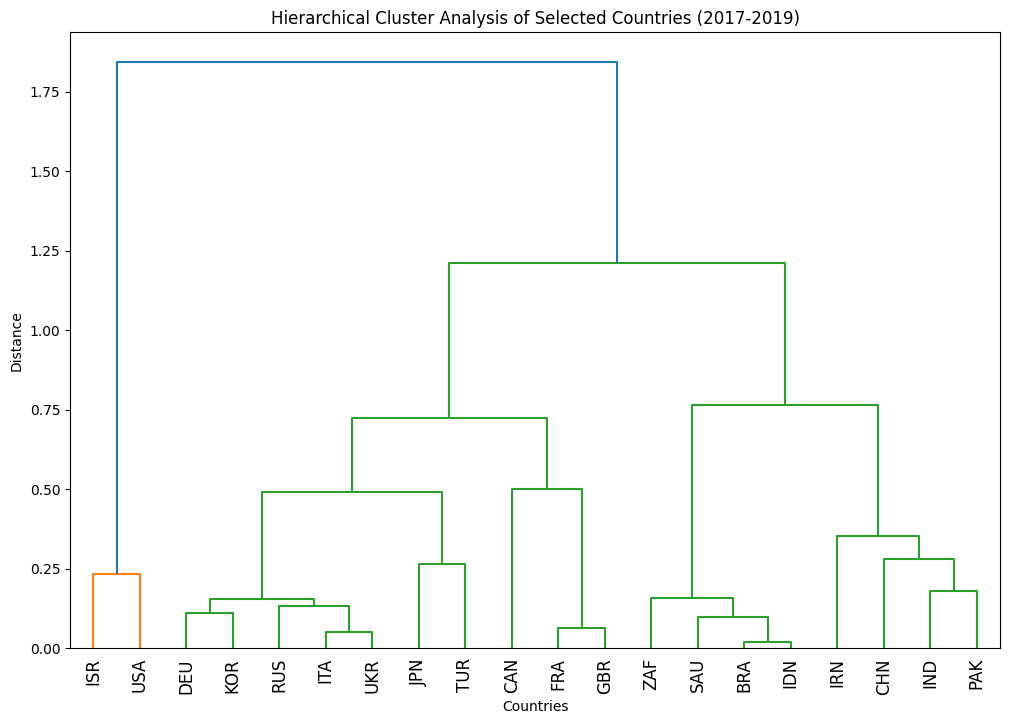

In [ ]:
# Define the selected group of countries
selected_countries = ["USA", "RUS", "CHN", "GBR", "FRA", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]

# Filter the data for the selected group of countries and the 2017-2019 period
votes_2017_2019_selected = votes[(votes['year'] >= 2017) & (votes['year'] <= 2019) & (votes['Country'].isin(selected_countries))]

# Pivot table to get "converted_votes" for each country
voting_data_selected = votes_2017_2019_selected.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between selected countries based on their "converted_votes"
distances_selected = pairwise_distances(voting_data_selected, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix_selected = 1 / (1 + distances_selected)

# Perform hierarchical clustering
linkage_matrix_selected = linkage(similarity_matrix_selected, method='average')  # You can choose other linkage methods as well

# Visualize the hierarchical clustering results as a dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix_selected, labels=voting_data_selected.index, leaf_rotation=90)
plt.title('Hierarchical Cluster Analysis of Selected Countries (2017-2019)')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.show()

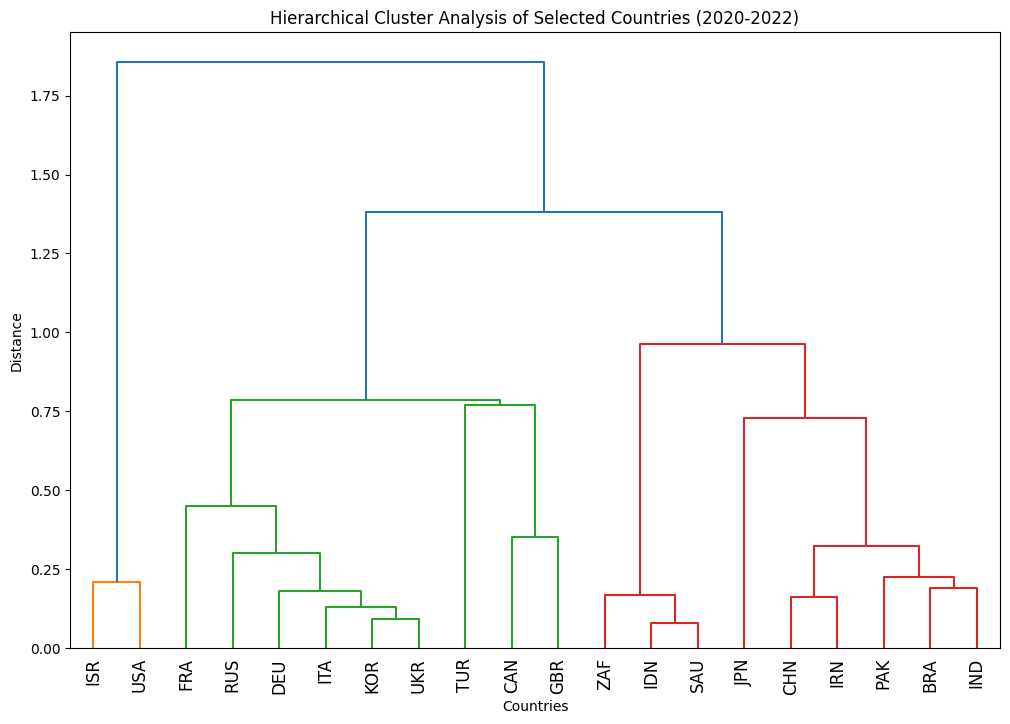

In [ ]:
# Define the selected group of countries
selected_countries = ["USA", "RUS", "CHN", "GBR", "FRA", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]

# Filter the data for the selected group of countries and the 2020-2022 period
votes_2020_2022_selected = votes[(votes['year'] >= 2020) & (votes['year'] <= 2022) & (votes['Country'].isin(selected_countries))]

# Pivot table to get "converted_votes" for each country
voting_data_selected = votes_2020_2022_selected.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Calculate pairwise distances between selected countries based on their "converted_votes"
distances_selected = pairwise_distances(voting_data_selected, metric='manhattan')  # Manhattan distance is the sum of absolute differences

# Create a similarity matrix by taking the reciprocal of distances
similarity_matrix_selected = 1 / (1 + distances_selected)

# Perform hierarchical clustering
linkage_matrix_selected = linkage(similarity_matrix_selected, method='average')  # You can choose other linkage methods as well

# Visualize the hierarchical clustering results as a dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix_selected, labels=voting_data_selected.index, leaf_rotation=90)
plt.title('Hierarchical Cluster Analysis of Selected Countries (2020-2022)')
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.show()

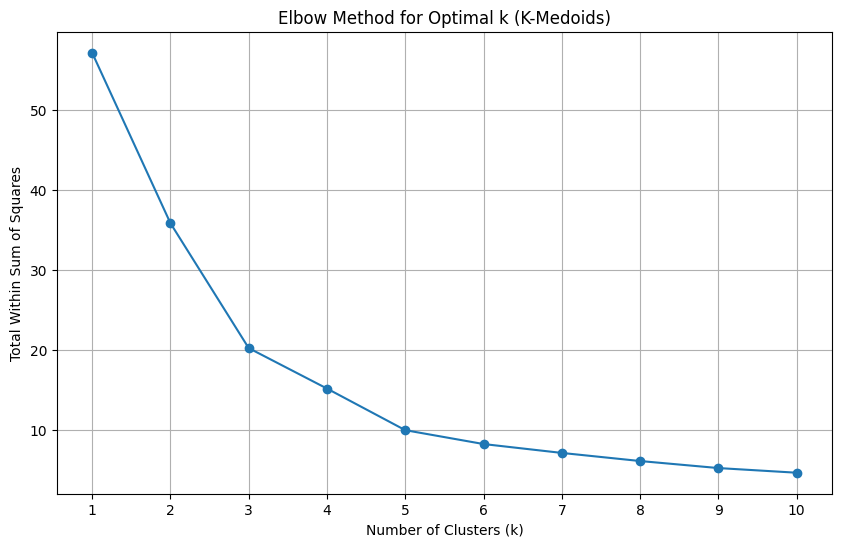

In [18]:
# Define the selected countries of interest
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA",
                      "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]

# Filter the data for the specified years (2011-2022) and selected countries
votes_selected = votes[(votes['year'] >= 2011) & (votes['year'] <= 2022) & (votes['Country'].isin(selected_countries))]

# Pivot table to get "converted_votes" for each selected country
voting_data_selected = votes_selected.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

# Convert DataFrame to numpy array
data_array = voting_data_selected.values

# Calculate distance matrix (absolute difference) for k-medoids clustering
def custom_distance_matrix(point1, point2):
    return np.sum(np.abs(point1 - point2))

# Define distance metric for k-medoids clustering
distance_func = distance_metric(type_metric.USER_DEFINED, func=custom_distance_matrix)

# Calculate total within sum of squares (inertia) for different values of k
inertia_values = []
k_values = range(1, 11)  # Test different values of k from 1 to 10

for k in k_values:
    # Initialize k-medoids algorithm with random initial medoids
    kmedoids_instance = kmedoids(data_array, initial_index_medoids=np.random.choice(len(data_array), k, replace=False), metric=distance_func)

    # Run k-medoids clustering
    kmedoids_instance.process()

    # Get clusters and calculate total within sum of squares (inertia)
    clusters = kmedoids_instance.get_clusters()
    inertia = 0
    for cluster in clusters:
        cluster_medoid = np.median(data_array[cluster], axis=0)
        for idx in cluster:
            inertia += custom_distance_matrix(data_array[idx], cluster_medoid)

    inertia_values.append(inertia)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k (K-Medoids)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Within Sum of Squares')
plt.xticks(k_values)
plt.grid(True)
plt.show()

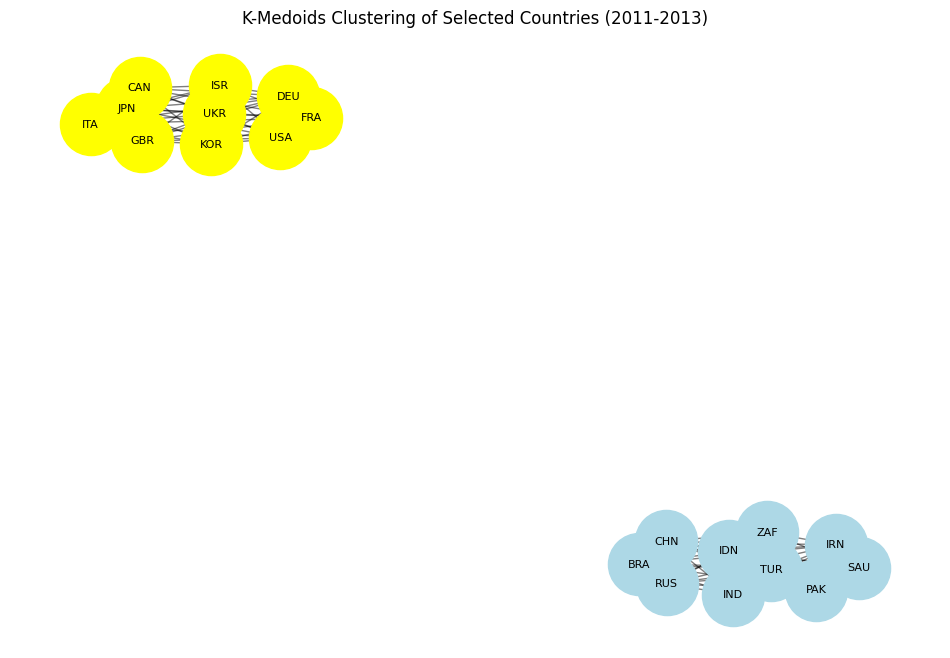

In [ ]:
# Filter the data for the selected countries and the 2011-2013 period
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]
votes_2011_2013_selected = votes[(votes['Country'].isin(selected_countries)) & (votes['year'] >= 2011) & (votes['year'] <= 2013)]

# Extract voting frequencies of "Yes" votes for each country
voting_data = votes_2011_2013_selected.pivot_table(index='Country', columns='year', values='votes', aggfunc=lambda x: (x == 1).sum(), fill_value=0)

# Convert to numpy array
X = voting_data.to_numpy()

# Perform k-medoids clustering
kmedoids = KMedoids(n_clusters=2, random_state=0)
clusters = kmedoids.fit_predict(X)

# Create a graph
G = nx.Graph()

# Add nodes for each country, color-coded by cluster
colors = ['lightblue', 'yellow']  # Define colors for each cluster
for country, cluster in zip(voting_data.index, clusters):
    G.add_node(country, color=colors[cluster])

# Add edges between nodes in the same cluster
for i, cluster in enumerate(clusters):
    for j, cluster2 in enumerate(clusters):
        if cluster == cluster2 and i != j:
            G.add_edge(voting_data.index[i], voting_data.index[j])

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph with nodes labeled with country names
plt.figure(figsize=(12, 8))
for node in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'], node_size=2000)
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('K-Medoids Clustering of Selected Countries (2011-2013)')
plt.axis('off')  # Turn off axis
plt.show()

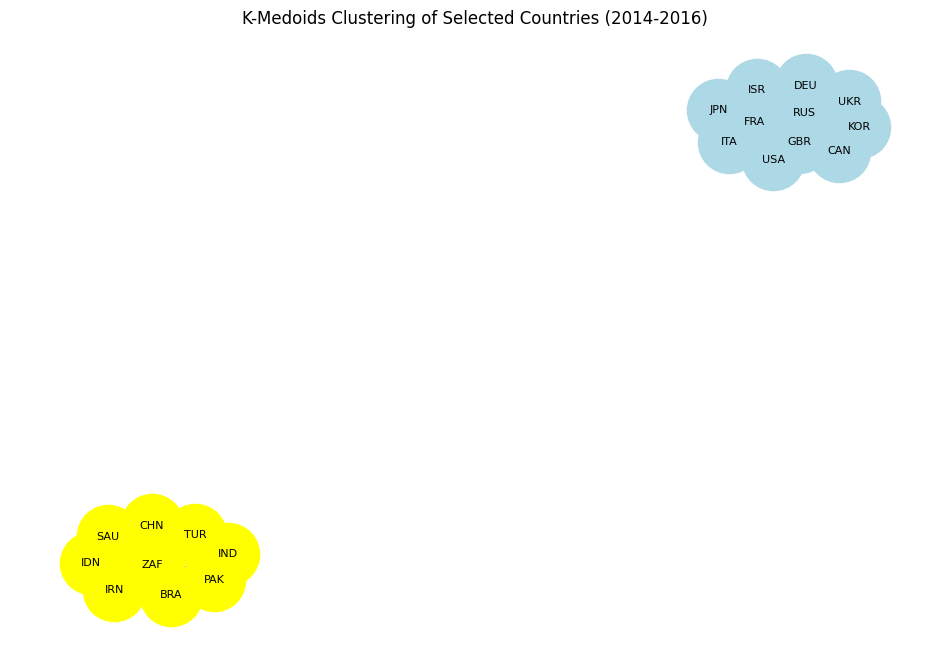

In [ ]:
# Filter the data for the selected countries and the 2014-2016 period
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]
votes_2014_2016_selected = votes[(votes['Country'].isin(selected_countries)) & (votes['year'] >= 2014) & (votes['year'] <= 2016)]

# Extract voting frequencies of "Yes" votes for each country
voting_data = votes_2014_2016_selected.pivot_table(index='Country', columns='year', values='votes', aggfunc=lambda x: (x == 1).sum(), fill_value=0)

# Convert to numpy array
X = voting_data.to_numpy()

# Perform k-medoids clustering
kmedoids = KMedoids(n_clusters=2, random_state=0)
clusters = kmedoids.fit_predict(X)

# Create a graph
G = nx.Graph()

# Add nodes for each country, color-coded by cluster
colors = ['lightblue', 'yellow']  # Define colors for each cluster
for country, cluster in zip(voting_data.index, clusters):
    G.add_node(country, color=colors[cluster])

# Add edges between nodes in the same cluster
for i, cluster in enumerate(clusters):
    for j, cluster2 in enumerate(clusters):
        if cluster == cluster2 and i != j:
            G.add_edge(voting_data.index[i], voting_data.index[j])

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph with nodes labeled with country names
plt.figure(figsize=(12, 8))
for node in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'], node_size=2000)
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('K-Medoids Clustering of Selected Countries (2014-2016)')
plt.axis('off')  # Turn off axis
plt.show()

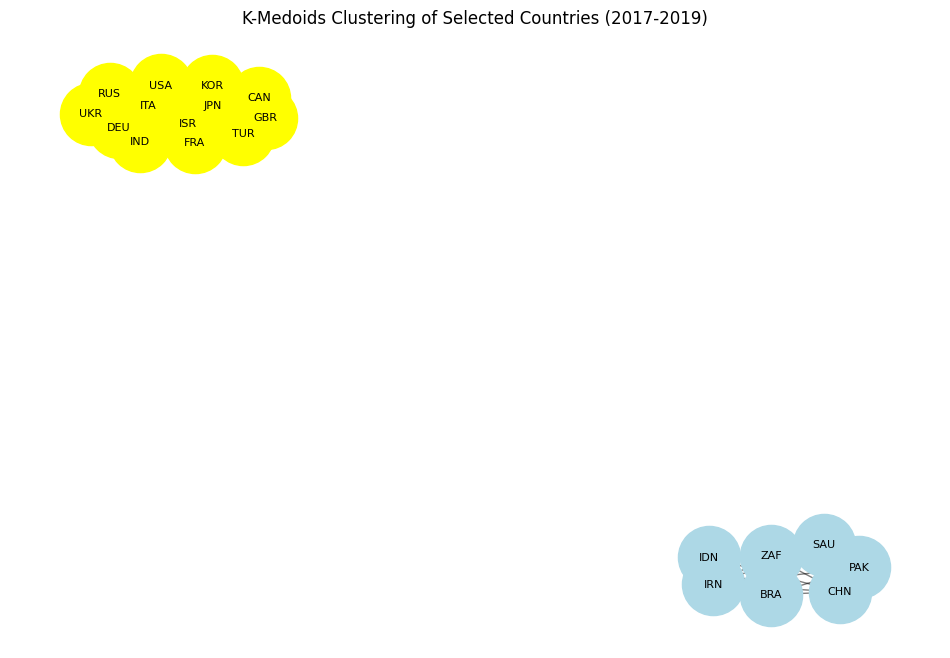

In [ ]:
# Filter the data for the selected countries and the 2017-2019 period
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]
votes_2017_2019_selected = votes[(votes['Country'].isin(selected_countries)) & (votes['year'] >= 2017) & (votes['year'] <= 2019)]

# Extract voting frequencies of "Yes" votes for each country
voting_data = votes_2017_2019_selected.pivot_table(index='Country', columns='year', values='votes', aggfunc=lambda x: (x == 1).sum(), fill_value=0)

# Convert to numpy array
X = voting_data.to_numpy()

# Perform k-medoids clustering
kmedoids = KMedoids(n_clusters=2, random_state=0)
clusters = kmedoids.fit_predict(X)

# Create a graph
G = nx.Graph()

# Add nodes for each country, color-coded by cluster
colors = ['lightblue', 'yellow']  # Define colors for each cluster
for country, cluster in zip(voting_data.index, clusters):
    G.add_node(country, color=colors[cluster])

# Add edges between nodes in the same cluster
for i, cluster in enumerate(clusters):
    for j, cluster2 in enumerate(clusters):
        if cluster == cluster2 and i != j:
            G.add_edge(voting_data.index[i], voting_data.index[j])

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph with nodes labeled with country names
plt.figure(figsize=(12, 8))
for node in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'], node_size=2000)
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('K-Medoids Clustering of Selected Countries (2017-2019)')
plt.axis('off')  # Turn off axis
plt.show()

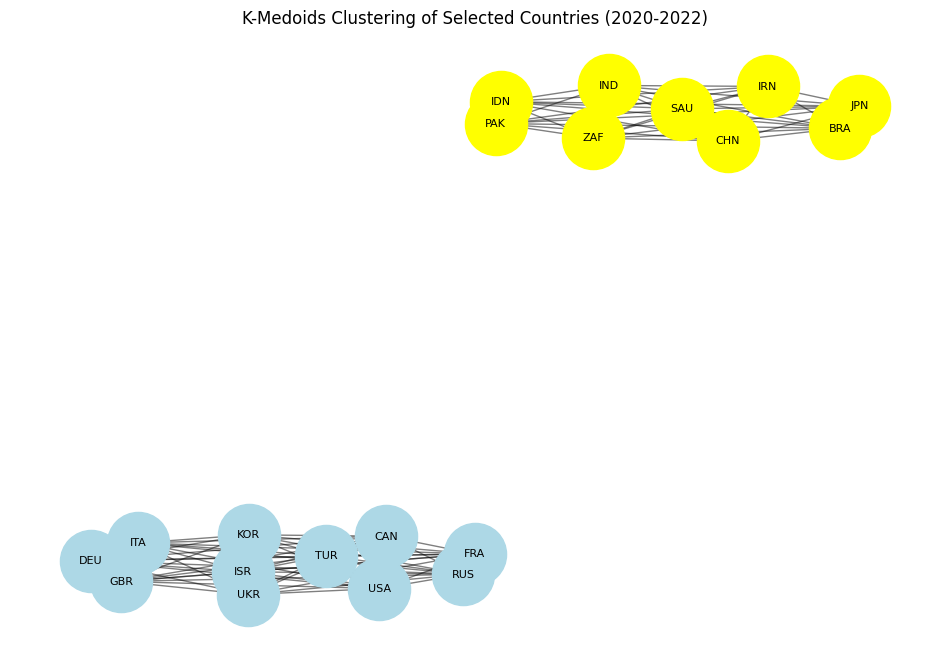

In [ ]:
# Filter the data for the selected countries and the 2020-2022 period
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]
votes_2020_2022_selected = votes[(votes['Country'].isin(selected_countries)) & (votes['year'] >= 2020) & (votes['year'] <= 2022)]

# Extract voting frequencies of "Yes" votes for each country
voting_data = votes_2020_2022_selected.pivot_table(index='Country', columns='year', values='votes', aggfunc=lambda x: (x == 1).sum(), fill_value=0)

# Convert to numpy array
X = voting_data.to_numpy()

# Perform k-medoids clustering
kmedoids = KMedoids(n_clusters=2, random_state=0)
clusters = kmedoids.fit_predict(X)

# Create a graph
G = nx.Graph()

# Add nodes for each country, color-coded by cluster
colors = ['lightblue', 'yellow']  # Define colors for each cluster
for country, cluster in zip(voting_data.index, clusters):
    G.add_node(country, color=colors[cluster])

# Add edges between nodes in the same cluster
for i, cluster in enumerate(clusters):
    for j, cluster2 in enumerate(clusters):
        if cluster == cluster2 and i != j:
            G.add_edge(voting_data.index[i], voting_data.index[j])

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph with nodes labeled with country names
plt.figure(figsize=(12, 8))
for node in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'], node_size=2000)
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('K-Medoids Clustering of Selected Countries (2020-2022)')
plt.axis('off')  # Turn off axis
plt.show()

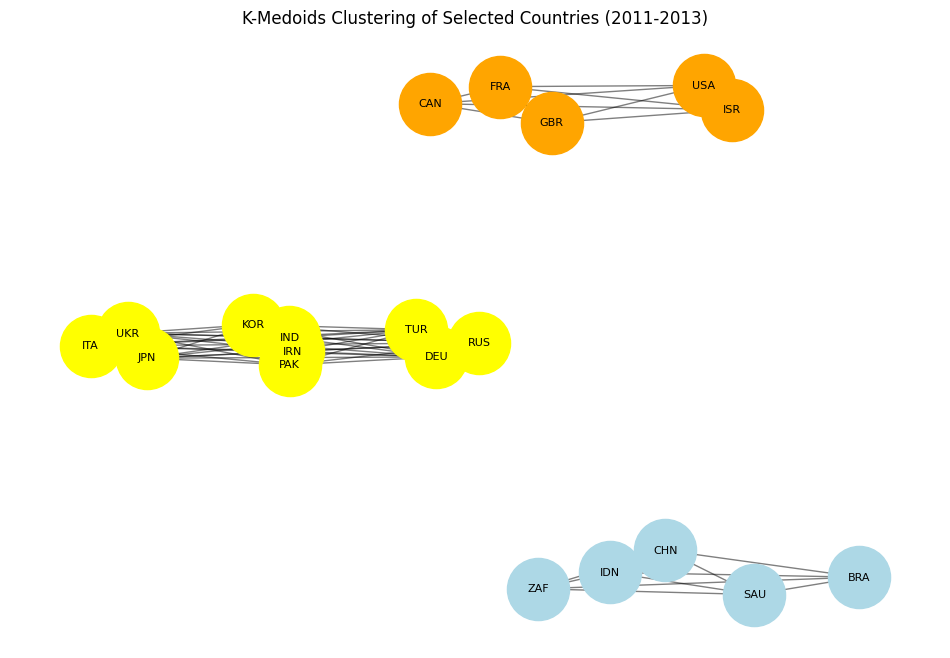

In [21]:
# Filter the data for the selected countries and the 2011-2013 period
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]
votes_2011_2013_selected = votes[(votes['Country'].isin(selected_countries)) & (votes['year'] >= 2011) & (votes['year'] <= 2013)]

# Extract voting frequencies of "Yes" votes for each country
voting_data = votes_2011_2013_selected.pivot_table(index='Country', columns='year', values='votes', aggfunc=lambda x: (x == 1).sum(), fill_value=0)

# Convert to numpy array
X = voting_data.to_numpy()

# Perform k-medoids clustering
kmedoids = KMedoids(n_clusters=3, random_state=0)
clusters = kmedoids.fit_predict(X)

# Create a graph
G = nx.Graph()

# Add nodes for each country, color-coded by cluster
colors = ['yellow', 'orange', 'lightblue']  # Define colors for each cluster
for country, cluster in zip(voting_data.index, clusters):
    G.add_node(country, color=colors[cluster])

# Add edges between nodes in the same cluster
for i, cluster in enumerate(clusters):
    for j, cluster2 in enumerate(clusters):
        if cluster == cluster2 and i != j:
            G.add_edge(voting_data.index[i], voting_data.index[j])

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph with nodes labeled with country names
plt.figure(figsize=(12, 8))
for node in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'], node_size=2000)
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('K-Medoids Clustering of Selected Countries (2011-2013)')
plt.axis('off')  # Turn off axis
plt.show()

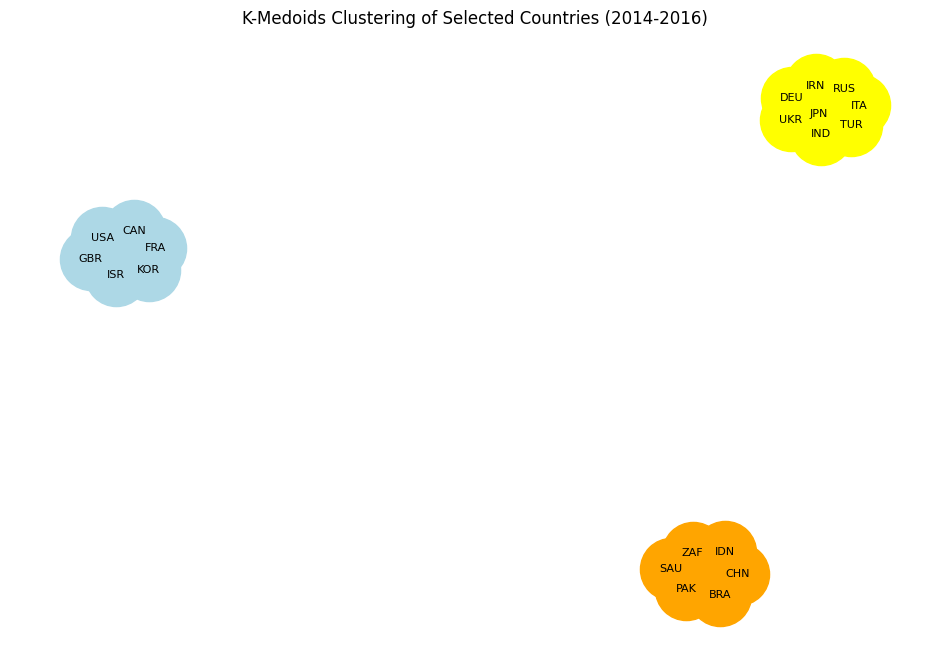

In [22]:
# Filter the data for the selected countries and the 2014-2016 period
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]
votes_2014_2016_selected = votes[(votes['Country'].isin(selected_countries)) & (votes['year'] >= 2014) & (votes['year'] <= 2016)]

# Extract voting frequencies of "Yes" votes for each country
voting_data = votes_2014_2016_selected.pivot_table(index='Country', columns='year', values='votes', aggfunc=lambda x: (x == 1).sum(), fill_value=0)

# Convert to numpy array
X = voting_data.to_numpy()

# Perform k-medoids clustering
kmedoids = KMedoids(n_clusters=3, random_state=0)
clusters = kmedoids.fit_predict(X)

# Create a graph
G = nx.Graph()

# Add nodes for each country, color-coded by cluster
colors = ['yellow', 'orange', 'lightblue']  # Define colors for each cluster
for country, cluster in zip(voting_data.index, clusters):
    G.add_node(country, color=colors[cluster])

# Add edges between nodes in the same cluster
for i, cluster in enumerate(clusters):
    for j, cluster2 in enumerate(clusters):
        if cluster == cluster2 and i != j:
            G.add_edge(voting_data.index[i], voting_data.index[j])

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph with nodes labeled with country names
plt.figure(figsize=(12, 8))
for node in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'], node_size=2000)
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('K-Medoids Clustering of Selected Countries (2014-2016)')
plt.axis('off')  # Turn off axis
plt.show()

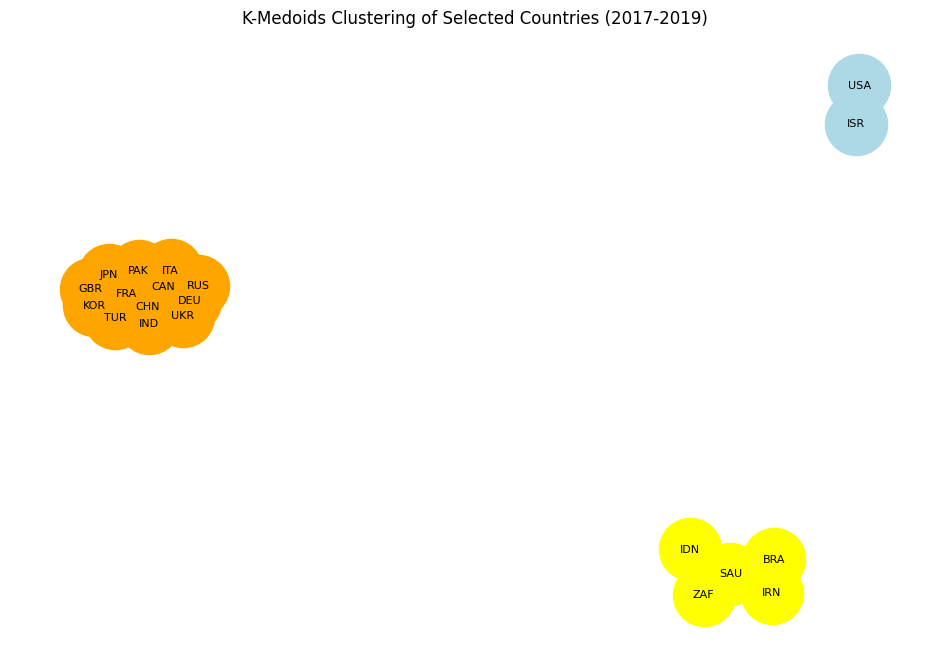

In [23]:
# Filter the data for the selected countries and the 2017-2019 period
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]
votes_2017_2019_selected = votes[(votes['Country'].isin(selected_countries)) & (votes['year'] >= 2017) & (votes['year'] <= 2019)]

# Extract voting frequencies of "Yes" votes for each country
voting_data = votes_2017_2019_selected.pivot_table(index='Country', columns='year', values='votes', aggfunc=lambda x: (x == 1).sum(), fill_value=0)

# Convert to numpy array
X = voting_data.to_numpy()

# Perform k-medoids clustering
kmedoids = KMedoids(n_clusters=3, random_state=0)
clusters = kmedoids.fit_predict(X)

# Create a graph
G = nx.Graph()

# Add nodes for each country, color-coded by cluster
colors = ['yellow', 'orange', 'lightblue']  # Define colors for each cluster
for country, cluster in zip(voting_data.index, clusters):
    G.add_node(country, color=colors[cluster])

# Add edges between nodes in the same cluster
for i, cluster in enumerate(clusters):
    for j, cluster2 in enumerate(clusters):
        if cluster == cluster2 and i != j:
            G.add_edge(voting_data.index[i], voting_data.index[j])

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph with nodes labeled with country names
plt.figure(figsize=(12, 8))
for node in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'], node_size=2000)
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('K-Medoids Clustering of Selected Countries (2017-2019)')
plt.axis('off')  # Turn off axis
plt.show()

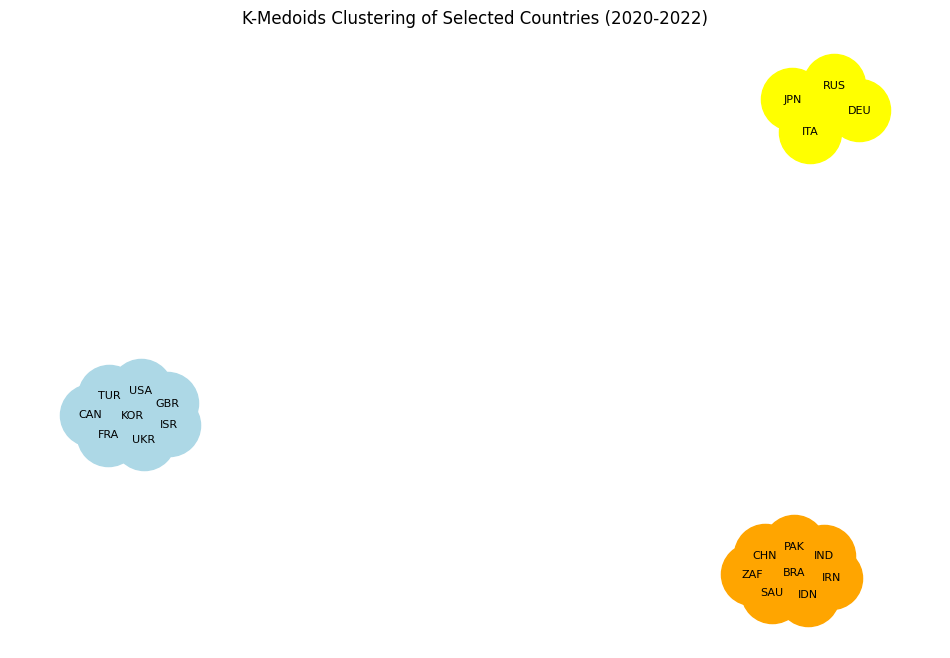

In [24]:
# Filter the data for the selected countries and the 2020-2022 period
selected_countries = ["USA", "RUS", "GBR", "FRA", "CHN", "BRA", "IND", "DEU", "JPN", "ITA", "CAN", "KOR", "PAK", "IRN", "ISR", "TUR", "SAU", "IDN", "ZAF", "UKR"]
votes_2020_2022_selected = votes[(votes['Country'].isin(selected_countries)) & (votes['year'] >= 2020) & (votes['year'] <= 2022)]

# Extract voting frequencies of "Yes" votes for each country
voting_data = votes_2020_2022_selected.pivot_table(index='Country', columns='year', values='votes', aggfunc=lambda x: (x == 1).sum(), fill_value=0)

# Convert to numpy array
X = voting_data.to_numpy()

# Perform k-medoids clustering
kmedoids = KMedoids(n_clusters=3, random_state=0)
clusters = kmedoids.fit_predict(X)

# Create a graph
G = nx.Graph()

# Add nodes for each country, color-coded by cluster
colors = ['yellow', 'orange', 'lightblue']  # Define colors for each cluster
for country, cluster in zip(voting_data.index, clusters):
    G.add_node(country, color=colors[cluster])

# Add edges between nodes in the same cluster
for i, cluster in enumerate(clusters):
    for j, cluster2 in enumerate(clusters):
        if cluster == cluster2 and i != j:
            G.add_edge(voting_data.index[i], voting_data.index[j])

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Draw the graph with nodes labeled with country names
plt.figure(figsize=(12, 8))
for node in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=G.nodes[node]['color'], node_size=2000)
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('K-Medoids Clustering of Selected Countries (2020-2022)')
plt.axis('off')  # Turn off axis
plt.show()

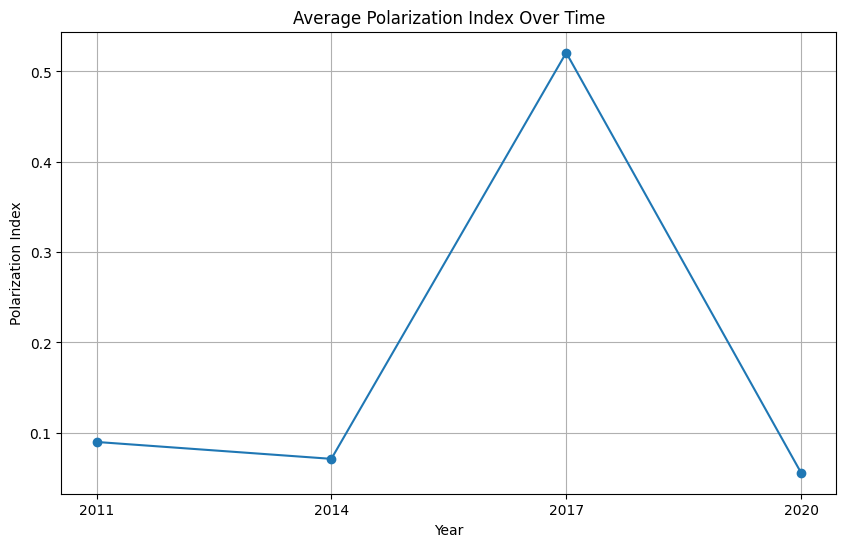

In [ ]:
# Define the periods
periods = [(2011, 2013), (2014, 2016), (2017, 2019), (2020, 2022)]

# Initialize list to store polarization index values
polarization_index_values = []

# Iterate over periods
for start_year, end_year in periods:
    # Filter the data for the specified period
    period_data = votes[(votes['year'] >= start_year) & (votes['year'] <= end_year)]

    # Pivot table to get "converted_votes" for each country
    voting_data = period_data.pivot_table(index='Country', columns='year', values='converted_votes', aggfunc='mean', fill_value=0)

    # Calculate cosine similarity between countries based on their "converted_votes"
    cos_sim = cosine_similarity(voting_data)

    # Average polarization index for the period
    polarization_index = np.mean(1 - cos_sim)  # 1 minus cosine similarity gives dissimilarity
    polarization_index_values.append(polarization_index)

# Visualize the polarization index values over time
plt.figure(figsize=(10, 6))
plt.plot(range(2011, 2023, 3), polarization_index_values, marker='o')
plt.title('Average Polarization Index Over Time')
plt.xlabel('Year')
plt.ylabel('Polarization Index')
plt.xticks(range(2011, 2023, 3))
plt.grid(True)
plt.show()

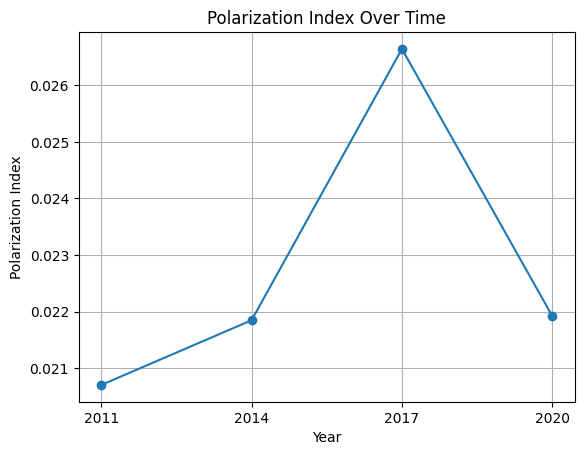

In [ ]:
# Define the periods
periods = [(2011, 2013), (2014, 2016), (2017, 2019), (2020, 2022)]

# Initialize lists to store polarization index values
polarization_index_values = []

# Calculate polarization index for each period
for start_year, end_year in periods:
    # Filter the data for the specified period
    period_data = votes[(votes['year'] >= start_year) & (votes['year'] <= end_year)]

    # Calculate voting patterns (e.g., frequency of "Yes" votes)
    # For simplicity, let's use the variance of "Yes" vote frequencies as the polarization index
    yes_vote_frequencies = period_data.groupby('Country')['votes'].apply(lambda x: (x == 1).mean())
    polarization_index = yes_vote_frequencies.var()

    # Append polarization index value
    polarization_index_values.append(polarization_index)

# Visualize the polarization index values over time
import matplotlib.pyplot as plt

plt.plot(range(2011, 2023, 3), polarization_index_values, marker='o')
plt.title('Polarization Index Over Time')
plt.xlabel('Year')
plt.ylabel('Polarization Index')
plt.xticks(range(2011, 2023, 3))
plt.grid(True)
plt.show()